In [34]:
# This Notebook loads a dataset to memory, calculates index, and plots the results

In [35]:
import datacube
import pandas
from datacube.storage import masking
from datacube.storage.masking import mask_invalid_data

dc = datacube.Datacube()

In [36]:
# Takes a region code, returns the lat/lon
def getRegion(l) :
#nwt   1         # burn before and after 
#vi    2         # coastal area
#hvm   3         # copper mine
#fmm   4         # oil sands
#pet   5         # research forest
#glc   6         # athabasca glaciers
    if l == 1 :
        lat = (62.3768, 63.3062)
        lon = (-114.7038, -112.3989)
    elif l == 2 :
        lat = (47.9432, 49.4273)
        lon = (-123.7845, -121.2920)
    elif l == 3 :
        lat = (49.7178, 50.8349)
        lon = (-121.6712, -119.7794)
    elif l == 4 :
        lat = (56.7849, 57.8174)
        lon = (-112.1411, -110.0301)
    elif l == 6 :
        lat = (51.1364, 52.2393)
        lon = (-117.9841, -116.0518)
    else :
        lat = (45.4499, 46.6034)
        lon = (-78.4944, -76.7130)
    return (lat, lon)

In [37]:
# Takes a product code, returns the associated bands
def getBands(p) :    
    prd = p[:4]
    
    if prd == 'LE07' :
        bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'panchromatic', 'quality']    
    elif prd == 'LM05' :
        bands = ['green', 'red', 'nir1', 'nir2', 'quality']    
    elif prd == 'LT05' :    
        bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'quality']    
    elif prd == 'LM03' :
        bands = ['green', 'red', 'nir1', 'nir2', 'quality']        
    else : 
        bands = ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'panchromatic', 'cirrus', 'lwir1', 'lwir2', 'quality']
    return bands

In [38]:
# Takes query parameters, returns query object
def buildQuery(p, b1, b2, t1, t2, l) :    

    lat, lon = getRegion(l)

    bands = getBands(p)
    
    query = { 
        'product' : p
        , 'latitude' : lat
        , 'longitude' : lon
        , 'measurements' : [ bands[b1], bands[b2], 'quality' ]
        , 'resolution' : (-0.0025, 0.0025)
    }

    if (t1 != '') and (t2 != '') :
        query['time'] = (t1, t2)
    
    return query

In [39]:
# Takes data, and bands, returns a Normalized Difference Index on them.
def plotIndex(data, b1, b2, p) :
    bands = getBands(p)
    
    band1 = mask_invalid_data(data.data_vars[bands[b1]])

    band2 = mask_invalid_data(data.data_vars[bands[b2]])
    
    index = ((band1 - band2) / (band1 + band2))
    
    return index

In [40]:
# Select a product
product = 'LC08_scene'

# Select band combination
band1 = 4
band2 = 3

band1, band2 = map(lambda x: x - 1,[band1, band2])

# Select a prepared region
#nwt   1         # burn before and after  46/16
#vi    2         # coastal area           47/26
#hvm   3         # copper mine            46/25
#fmm   4         # oil sands              42/20
#pet   5         # research forest        17/28
#glc   6         # athabasca glaciers     44/24

region = 1

# Select time start and end
start = ''
end = ''

In [41]:
query = buildQuery(product, band1, band2, start, end, region)
data = dc.load( **query)
index = plotIndex(data, band1, band2, product)

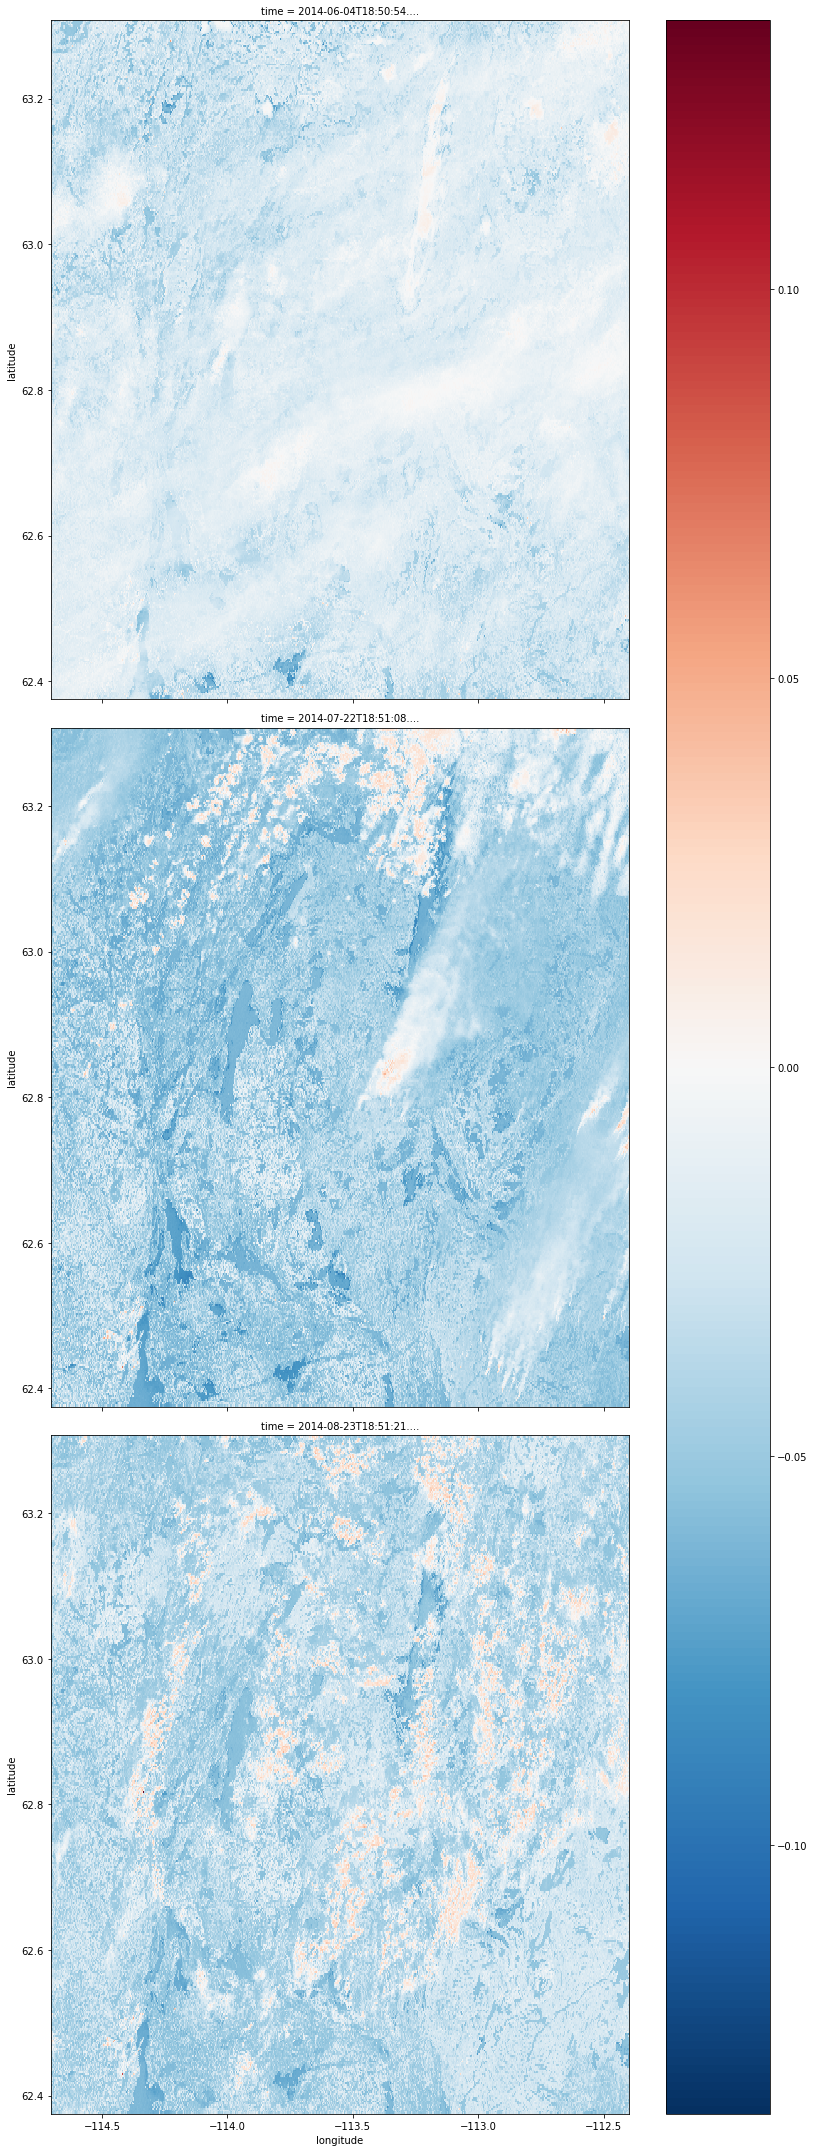

In [42]:
index.plot(x = data.crs.dimensions[1], y = data.crs.dimensions[0], col='time', col_wrap = 1, size = 10)

In [43]:
# Make a mask for the quality band,
cloudFree = masking.make_mask(data.quality, cloud = False)

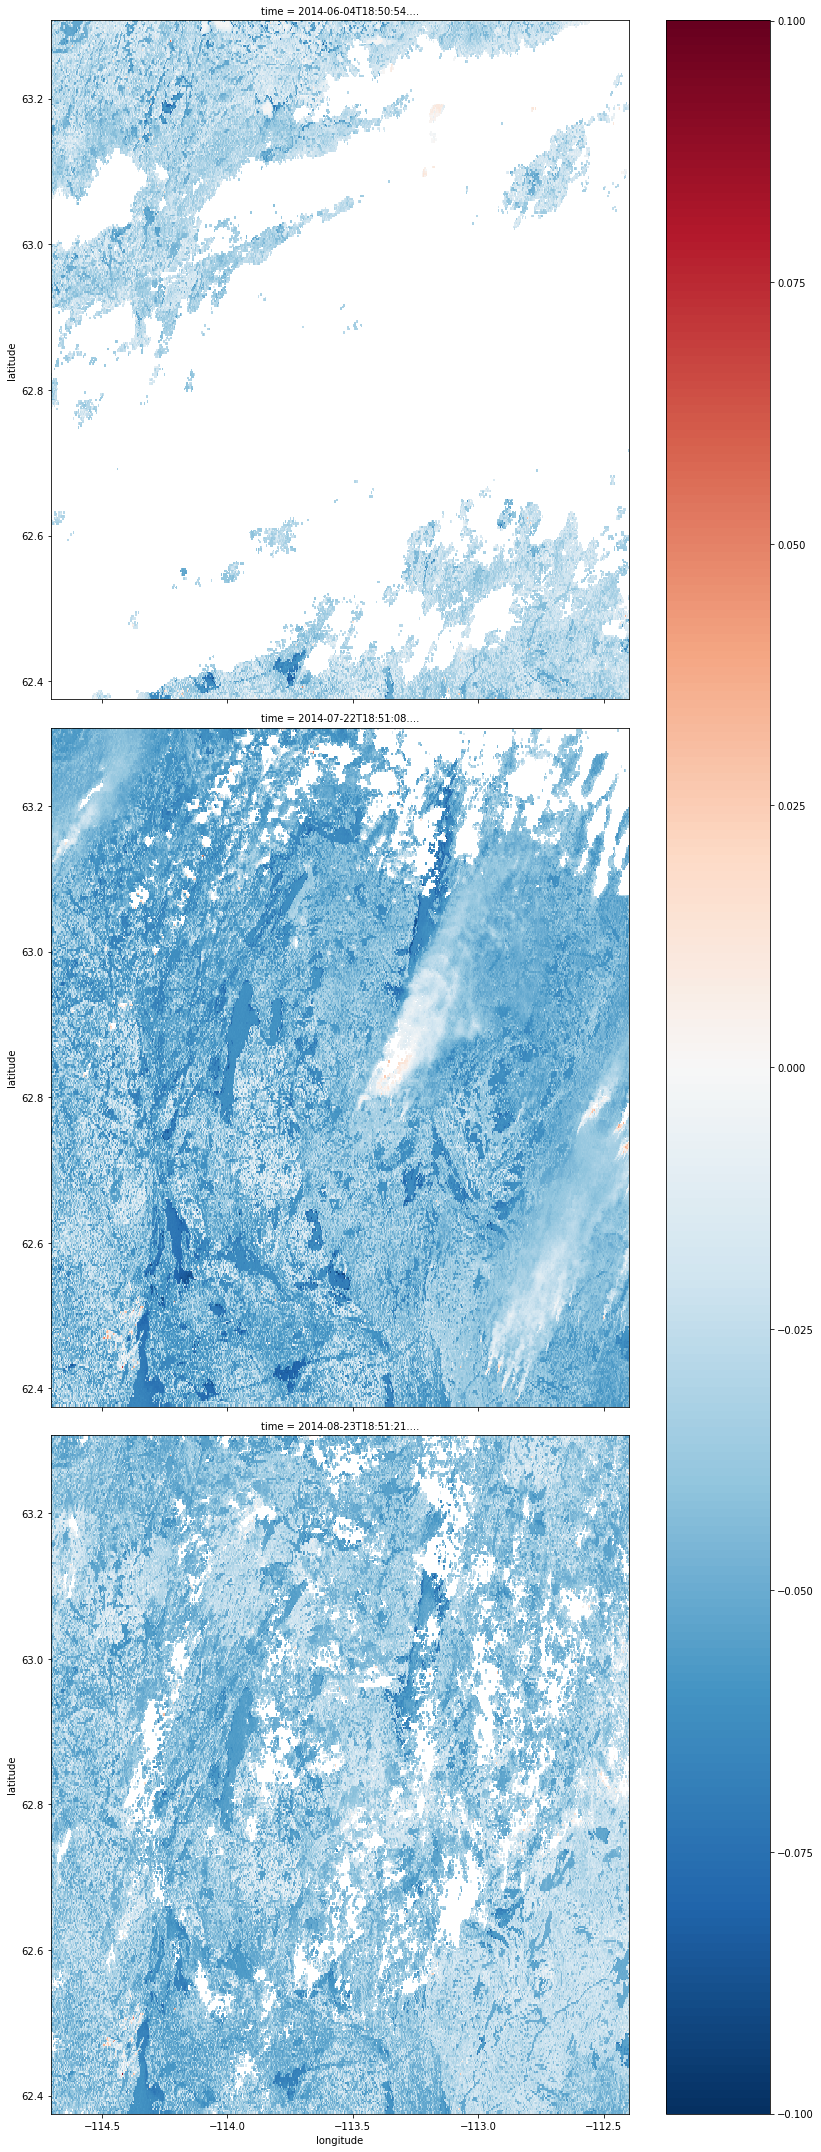

In [44]:
index.where(cloudFree).plot(x = data.crs.dimensions[1], y = data.crs.dimensions[0], col='time', col_wrap = 1, size = 10)